In [ ]:
# imports
import pandas as pd
from functions import *
import requests
from dotenv import dotenv_values
import time
from pathlib import Path
from os.path import expanduser
from datetime import datetime
import matplotlib.pyplot as plt
import sqlalchemy
import numpy as np
import json
import os
import requests


In [ ]:
songs = pd.read_csv('/Users/jasperkaninck/neuefische/Capstone/Notebooks/data/18k_complete.csv')
aus = pd.read_csv('/Users/jasperkaninck/neuefische/Capstone/Notebooks/data/Top100_Australia.csv')
usa = pd.read_csv('/Users/jasperkaninck/neuefische/Capstone/Notebooks/data/Top100_UnitedStates.csv')

In [ ]:
songs.head()

In [ ]:
usa.shape

In [ ]:
aus.head()

In [ ]:
songs.columns

In [ ]:
import pandas as pd

# Assuming 'aus' and 'songs' are already defined pandas DataFrames
# Now, let's merge 'aus' with 'songs' on the 'track_id' column

songs_aus = pd.merge(aus, songs, on='track_id', how='left')

# The 'how='left'' parameter ensures that all records from 'aus' are included in the merged dataframe
# and those in 'songs' are matched where possible, according to 'track_id'.

# Check the result
print(songs_aus.head())


In [ ]:
songs_aus.info()

In [ ]:
songs_aus.describe()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(songs_aus['duration_ms'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Song Durations')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')
plt.show()



In [ ]:
import pandas as pd

# Assuming 'merged_df' is the merged DataFrame that already exists

# Convert 'duration_ms' to 'mm:ss' format
def convert_ms_to_min_sec(duration_ms):
    seconds = int((duration_ms / 1000) % 60)
    minutes = int((duration_ms / (1000 * 60)) % 60)
    # Format seconds to always include leading zero when necessary
    return f"{minutes}:{seconds:02d}"

# Apply the conversion function to each row in the 'duration_ms' column
songs_aus['duration_min_sec'] = songs_aus['duration_ms'].apply(convert_ms_to_min_sec)

# Display the first few rows to verify the new column
print(songs_aus[['duration_ms', 'duration_min_sec']].head())


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Assume songs_aus is your DataFrame and you have already cleaned your dataset

# Define your features and label
X = songs_aus[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
y = songs_aus['rank']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Create interaction terms (only interaction, not polynomial features)
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = interaction.fit_transform(X)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Wir verwenden die vorher definierten Features für das Clustering
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = songs[features]

# Standardisieren der Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DBSCAN-Clustering
db = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)

# Labels der Cluster hinzufügen
songs['cluster_label'] = db.labels_

# Überprüfen der Cluster-Ergebnisse
print(songs['cluster_label'].value_counts())

# Visualisierung der Cluster (optional, wählen Sie zwei Features für eine 2D-Darstellung)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=db.labels_, cmap='Paired')
plt.xlabel('Feature 1 (standardisiert)')
plt.ylabel('Feature 2 (standardisiert)')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
songs.columns

In [ ]:
client_id = dotenv_values('.env')['spotify_id']
client_secret = dotenv_values('.env')['spotify_secret']

In [ ]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import threading


def api_call_with_timeout(sp, track_id, timeout=10):
    # This function will make the API call and return the result or None if it times out
    result = [None]  # Using a list to hold the result so it can be modified inside the inner function

    def api_call():
        try:
            track_info = sp.track(track_id)
            artist_id = track_info['artists'][0]['id']
            genres = get_genres(sp, artist_id)
            result[0] = ', '.join(genres)
        except Exception as e:
            print(f"Error during API call for track ID {track_id}: {e}")

    thread = threading.Thread(target=api_call)
    thread.start()
    thread.join(timeout)

    if thread.is_alive():
        print(f"Timeout for track ID {track_id}")
        thread.join()  # Optionally, you can forcefully terminate the thread here
        return None

    return result[0]


# List of credentials
credentials_list = [
    "f4bb0b44c47e4ea1a1f091f1fabdbeb3", "3d9630e1d1f3458f91d2e43434429dee",
    "bf6e433f86274e6897d5962ed6fe2d84", "980284f26e3342be9e3b23d00f99d628",
    "c60264c962584c55ba39b250ce1f60a9", "71694bb7c92848fa989fa2174a9f2d9a",
    "52d4b223df3646fd8539ed7a3fc210ae", "7c40e68fb03b42ff91aefff461755452",
    "28dcd8fe209943b1858faf48207e15b5", "fe3d6837104244efb1dbe1e3f4e9e972",
    "1a20329622b84b9083e0ceb4dc83f0b6", "33e9ed5c3b994f5cb753c7d372f02511",
    "d7cd64060d6644ce9c21a55d6b0fad5f", "58c904195b2d4b1582096fa59bd601da",
    "e7cf48db9226404cac27f4e7565f876d", "925cbad3bd0a442ca0fdc46fc59a4dd0",
    "e1d0fbf0a82148718d568cddd0247376", "252220859f2a48758d982fcb8dbc5c05",
    "e782e9c066d64aa6825037bba85419f3", "6cf3725aa5b04417869adf66ce8037d6"
]

# Create a dictionary of Spotify credentials
spotify_credentials = {}
for i in range(0, len(credentials_list), 2):
    spotify_credentials[f'cred{i//2 + 1}'] = {
        'client_id': credentials_list[i],
        'client_secret': credentials_list[i + 1]
    }

# Function to initialize Spotipy with given credentials
def init_spotipy(client_id, client_secret):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    return spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Function to safely fetch genres for an artist
def get_genres(sp, artist_id):
    try:
        artist_info = sp.artist(artist_id)
        return artist_info['genres']
    except spotipy.SpotifyException as e:
        print(f"SpotifyException: {e}")
        return []
    except Exception as e:
        print(f"Exception: {e}")
        return []

# Load the DataFrame
print("Loading DataFrame...")
songs = pd.read_csv('/Users/jasperkaninck/neuefische/Capstone/Notebooks/data/18k_complete.csv')
print(f"DataFrame loaded with {len(songs)} rows.")

# Add a new column for genres in the DataFrame if it doesn't exist
if 'genres' not in songs.columns:
    songs['genres'] = None

# Checkpointing: Load the last index if exists
try:
    with open('checkpoint.txt', 'r') as f:
        start_index = int(f.read().strip())
except FileNotFoundError:
    start_index = 0

# Define the number of rows to process per run and per save
rows_per_run = 2000
rows_per_save = 100

# Iterate over the credentials
for cred_key, creds in spotify_credentials.items():
    print(f"Using credentials: {cred_key}")
    sp = init_spotipy(creds['client_id'], creds['client_secret'])
    processed_rows = 0

    # Process the tracks starting from the last checkpoint
    for index, row in songs.iloc[start_index:].iterrows():
    if processed_rows >= rows_per_run:
        break

    track_id = row['track_id']
    genres = api_call_with_timeout(sp, track_id)

    if genres is not None:
        # Update the DataFrame with the genres
        songs.at[index, 'genres'] = genres
    else:
        # Handle the timeout case, e.g., retry or skip
        # ...

    # ... rest of your loop ...


        track_id = row['track_id']
        print(f"Processing track ID: {track_id}")
        try:
            track_info = sp.track(track_id)
            artist_id = track_info['artists'][0]['id']
            genres = get_genres(sp, artist_id)
            
            # Update the DataFrame with the genres
            songs.at[index, 'genres'] = ', '.join(genres)
        except spotipy.SpotifyException as e:
            print(f"SpotifyException for track ID {track_id}: {e}")
        except Exception as e:
            print(f"Exception for track ID {track_id}: {e}")

        # Sleep to avoid hitting the rate limit
        time.sleep(0.1)

        processed_rows += 1

        # Save the DataFrame every 1000 rows
        if processed_rows % rows_per_save == 0 or processed_rows >= rows_per_run:
            songs.to_csv('updated_tracks_with_genres.csv', index=False)
            with open('checkpoint.txt', 'w') as f:
                f.write(str(index))

        # Optional: print progress
        print(f"Processed track {index+1}/{len(songs)}")

    start_index += processed_rows  # Update start_index for the next credential
    print(f"Completed processing with {cred_key}. Processed rows: {processed_rows}")

    if start_index >= len(songs):
        print("All songs have been processed.")
        break  # Break if all songs have been processed


In [2]:
import pandas as pd
import requests
import time
import os
import base64
import json
import threading

def get_spotify_token(client_id, client_secret):
    # Kodieren der Client-ID und des Client-Secrets
    client_creds = f"{client_id}:{client_secret}"
    client_creds_b64 = base64.b64encode(client_creds.encode())

    # Token URL
    token_url = "https://accounts.spotify.com/api/token"
    token_data = {"grant_type": "client_credentials"}
    token_headers = {"Authorization": f"Basic {client_creds_b64.decode()}"}

    # Token Anfrage
    r = requests.post(token_url, data=token_data, headers=token_headers)
    token_response_data = r.json()
    access_token = token_response_data['access_token']

    return access_token

def api_call_with_timeout(access_token, track_id, timeout=10):
    result = [None]

    def api_call():
        try:
            track_url = f"https://api.spotify.com/v1/tracks/{track_id}"
            artist_url = "https://api.spotify.com/v1/artists/"
            headers = {"Authorization": f"Bearer {access_token}"}

            track_response = requests.get(track_url, headers=headers)
            if track_response.status_code != 200:
                raise Exception(f"Track API request failed with status code {track_response.status_code}")

            track_info = track_response.json()
            artist_id = track_info['artists'][0]['id']
            
            artist_response = requests.get(artist_url + artist_id, headers=headers)
            if artist_response.status_code != 200:
                raise Exception(f"Artist API request failed with status code {artist_response.status_code}")

            artist_info = artist_response.json()
            result[0] = ', '.join(artist_info['genres'])
        except Exception as e:
            print(f"Error during API call for track ID {track_id}: {e}")

    thread = threading.Thread(target=api_call)
    thread.start()
    thread.join(timeout)

    if thread.is_alive():
        print(f"Timeout for track ID {track_id}")
        thread.join()
        return None

    return result[0]

# Manuelle Eingabe der Spotify-API-Credentials
client_id = input("Enter Spotify Client ID: ")
client_secret = input("Enter Spotify Client Secret: ")

# Token erhalten
access_token = get_spotify_token(client_id, client_secret)

print("Loading DataFrame...")
songs = pd.read_csv('/Users/jasperkaninck/neuefische/Capstone/Notebooks/data/18k_complete.csv')  # Pfad zur CSV-Datei
print(f"DataFrame loaded with {len(songs)} rows.")

if 'genres' not in songs.columns:
    songs['genres'] = None

# Manuelle Eingabe der zu verarbeitenden Zeilenindizes
start_index = int(input("Enter start index: "))
end_index = int(input("Enter end index: "))

rows_per_save = 100  # Speichern nach jeder n-ten Zeile

for index, row in songs.iloc[start_index:end_index].iterrows():
    track_id = row['track_id']
    genres = api_call_with_timeout(access_token, track_id)

    if genres is not None:
        songs.at[index, 'genres'] = genres

    time.sleep(0.1)

    if (index - start_index + 1) % rows_per_save == 0 or index == end_index - 1:
        songs.to_csv('updated_tracks_with_genres.csv', index=False)
        print(f"Processed and saved up to index {index}")

print("Processing complete.")


Loading DataFrame...
DataFrame loaded with 18710 rows.
Processed and saved up to index 2599
Processed and saved up to index 2699
Processed and saved up to index 2799
Processed and saved up to index 2899
Processed and saved up to index 2999
Error during API call for track ID 18yA8SEzQEZkBBTs34gAlK: Track API request failed with status code 502
Error during API call for track ID 4zQR1bvSSRbANaJ4TFcfsY: Track API request failed with status code 502
Error during API call for track ID 7ms3VzLTfr7fXNOqA4Mkx9: Track API request failed with status code 502
Error during API call for track ID 7fGgwghPEYYSVnq58pxkay: Track API request failed with status code 502
Processed and saved up to index 3099
Error during API call for track ID 3dVvWnj4D8JGkKvo6Hucso: Track API request failed with status code 502
Error during API call for track ID 5cQMfg4AEejKUfNA44ZGep: Track API request failed with status code 502
Error during API call for track ID 6JvyHkxpltsajivAPubsOO: Track API request failed with stat

In [14]:
import pandas as pd
import requests
import time
import os
import base64
import json
import threading

def get_spotify_token(client_id, client_secret):
    # Kodieren der Client-ID und des Client-Secrets
    client_creds = f"{client_id}:{client_secret}"
    client_creds_b64 = base64.b64encode(client_creds.encode())

    # Token URL
    token_url = "https://accounts.spotify.com/api/token"
    token_data = {"grant_type": "client_credentials"}
    token_headers = {"Authorization": f"Basic {client_creds_b64.decode()}"}

    # Token Anfrage
    r = requests.post(token_url, data=token_data, headers=token_headers)
    token_response_data = r.json()
    access_token = token_response_data['access_token']

    return access_token

def api_call_with_timeout(access_token, track_id, timeout=10):
    result = [None]

    def api_call():
        try:
            track_url = f"https://api.spotify.com/v1/tracks/{track_id}"
            artist_url = "https://api.spotify.com/v1/artists/"
            headers = {"Authorization": f"Bearer {access_token}"}

            track_response = requests.get(track_url, headers=headers)
            if track_response.status_code != 200:
                raise Exception(f"Track API request failed with status code {track_response.status_code}")

            track_info = track_response.json()
            artist_id = track_info['artists'][0]['id']
            
            artist_response = requests.get(artist_url + artist_id, headers=headers)
            if artist_response.status_code != 200:
                raise Exception(f"Artist API request failed with status code {artist_response.status_code}")

            artist_info = artist_response.json()
            result[0] = ', '.join(artist_info['genres'])
        except Exception as e:
            print(f"Error during API call for track ID {track_id}: {e}")

    thread = threading.Thread(target=api_call)
    thread.start()
    thread.join(timeout)

    if thread.is_alive():
        print(f"Timeout for track ID {track_id}")
        thread.join()
        return None

    return result[0]

# Manuelle Eingabe der Spotify-API-Credentials
client_id = input("Enter Spotify Client ID: ")
client_secret = input("Enter Spotify Client Secret: ")

# Token erhalten
access_token = get_spotify_token(client_id, client_secret)

print("Loading DataFrame...")
songs = pd.read_csv('/Users/jasperkaninck/neuefische/Capstone/Notebooks/data/18k_complete.csv')  # Pfad zur CSV-Datei
print(f"DataFrame loaded with {len(songs)} rows.")

if 'genres' not in songs.columns:
    songs['genres'] = None

# Manuelle Eingabe der zu verarbeitenden Zeilenindizes
start_index = int(input("Enter start index: "))
end_index = int(input("Enter end index: "))

rows_per_save = 100  # Speichern nach jeder n-ten Zeile

temp_output_file = f'updated_tracks_with_genres_part_{start_index}_{end_index}.csv'

for index, row in songs.iloc[start_index:end_index].iterrows():
    track_id = row['track_id']
    genres = api_call_with_timeout(access_token, track_id)

    if genres is not None:
        songs.at[index, 'genres'] = genres

    time.sleep(0.1)

    if (index - start_index + 1) % rows_per_save == 0 or index == end_index - 1:
        # Speichern der aktualisierten Zeilen in einer temporären Datei
        updated_rows = songs.iloc[start_index:index + 1]
        updated_rows.to_csv(temp_output_file, index=False)
        print(f"Processed and saved up to index {index}")


print("Processing complete.")


Loading DataFrame...
DataFrame loaded with 18710 rows.
Processed and saved up to index 16100
Processed and saved up to index 16200
Processed and saved up to index 16300
Processed and saved up to index 16400
Processed and saved up to index 16500
Processed and saved up to index 16600
Processed and saved up to index 16700
Processed and saved up to index 16800
Processed and saved up to index 16900
Processed and saved up to index 17000
Processed and saved up to index 17100
Processed and saved up to index 17200
Processed and saved up to index 17300
Processed and saved up to index 17400
Processed and saved up to index 17500
Processed and saved up to index 17600
Processed and saved up to index 17700
Processed and saved up to index 17800
Processed and saved up to index 17900
Processed and saved up to index 17999
Processing complete.


In [15]:
import pandas as pd
import os

# Pfad zum Verzeichnis, in dem sich Ihre CSV-Dateien befinden
directory = '/Users/jasperkaninck/neuefische/Capstone/Notebooks/data'

# Liste, um die Datenframes zu speichern
dfs = []

# Durchlaufen Sie alle Dateien im Verzeichnis
for filename in os.listdir(directory):
    if filename.startswith('updated_tracks_with_genres_part_') and filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)

# Kombinieren Sie alle Datenframes in der Liste
combined_df = pd.concat(dfs, ignore_index=True)

# Speichern Sie das kombinierte DataFrame in einer neuen CSV-Datei
combined_df.to_csv('18k_genres.csv', index=False)


In [36]:
import pandas as pd

# CSV-Datei einlesen
df = pd.read_csv('/Users/jasperkaninck/neuefische/Capstone/Notebooks/data/18k_genres_clean.csv')

# Liste der gewünschten Genres
desired_genres = ["K-Pop","J-Pop", "Rock", "Rap", "EDM","Reggae", "Hip Hop", "Classical", "Lounge", "Soul", "Indie", "Disco", "Metal", "Latin", "Dance", "Folk", "Pop", "Jazz", "Country", "Alternative", "Punk"]

def clean_genres(genres):
    # Überprüfen, ob genres ein String ist
    if not isinstance(genres, str):
        return ""  # oder wie Sie mit nicht-String-Werten umgehen möchten

    # Teilt den String in eine Liste von Genres
    genre_list = genres.split(', ')
    # Filtert die Liste, um nur gewünschte Genres zu behalten
    filtered_genres = set()  # Verwenden Sie ein Set, um Duplikate zu vermeiden
    for genre in genre_list:
        for desired_genre in desired_genres:
            if desired_genre.lower() in genre.lower():
                filtered_genres.add(desired_genre)
                break  # Beendet die innere Schleife, wenn ein Genre gefunden wurde
    # Konvertiert das Set zurück in einen String
    return ', '.join(filtered_genres)

# Wenden Sie die Funktion auf die Genres-Spalte an
df['genres'] = df['genres'].apply(clean_genres)

# Ergebnis speichern
df.to_csv('18k_clean_updated.csv', index=False)

def clean_genres(genres):
    # Teilt den String in eine Liste von Genres
    genre_list = genres.split(', ')
    # Filtert die Liste, um nur gewünschte Genres zu behalten
    filtered_genres = set()  # Verwenden Sie ein Set, um Duplikate zu vermeiden
    for genre in genre_list:
        for desired_genre in desired_genres:
            if desired_genre.lower() in genre.lower():
                filtered_genres.add(desired_genre)
                break  # Beendet die innere Schleife, wenn ein Genre gefunden wurde
    # Konvertiert das Set zurück in einen String
    return ', '.join(filtered_genres)

# Wenden Sie die Funktion auf die Genres-Spalte an
df['genres'] = df['genres'].apply(clean_genres)

# Ergebnis speichern
df.to_csv('18k_clean_updated.csv', index=False)


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18701 entries, 0 to 18700
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               18701 non-null  object 
 1   artist              18701 non-null  object 
 2   track_id            18701 non-null  object 
 3   danceability        18701 non-null  float64
 4   energy              18701 non-null  float64
 5   key                 18701 non-null  int64  
 6   loudness            18701 non-null  float64
 7   mode                18701 non-null  int64  
 8   speechiness         18701 non-null  float64
 9   acousticness        18701 non-null  float64
 10  instrumentalness    18701 non-null  float64
 11  liveness            18701 non-null  float64
 12  valence             18701 non-null  float64
 13  tempo               18701 non-null  float64
 14  duration_ms         18701 non-null  int64  
 15  popularity          18701 non-null  int64  
 16  albu

In [38]:
import pandas as pd

# Angenommen, df ist Ihre ursprüngliche DataFrame

# Schritt 1: Trennen der Genres in separate Zeilen
all_genres = df['genres'].str.split(', ', expand=True).stack()
all_genres.index = all_genres.index.droplevel(-1)  # Entfernt den inneren Index
all_genres.name = 'genre'  # Benennt die Serie um

# Schritt 2: Verwenden von get_dummies
dummies = pd.get_dummies(all_genres).groupby(level=0).sum()

# Schritt 3: Zusammenführen der ursprünglichen DataFrame mit den Dummy-Variablen
df = df.drop('genres', axis=1).join(dummies)

# Ergebnis speichern
df.to_csv('18k_clean_updated_with_dummies.csv', index=False)


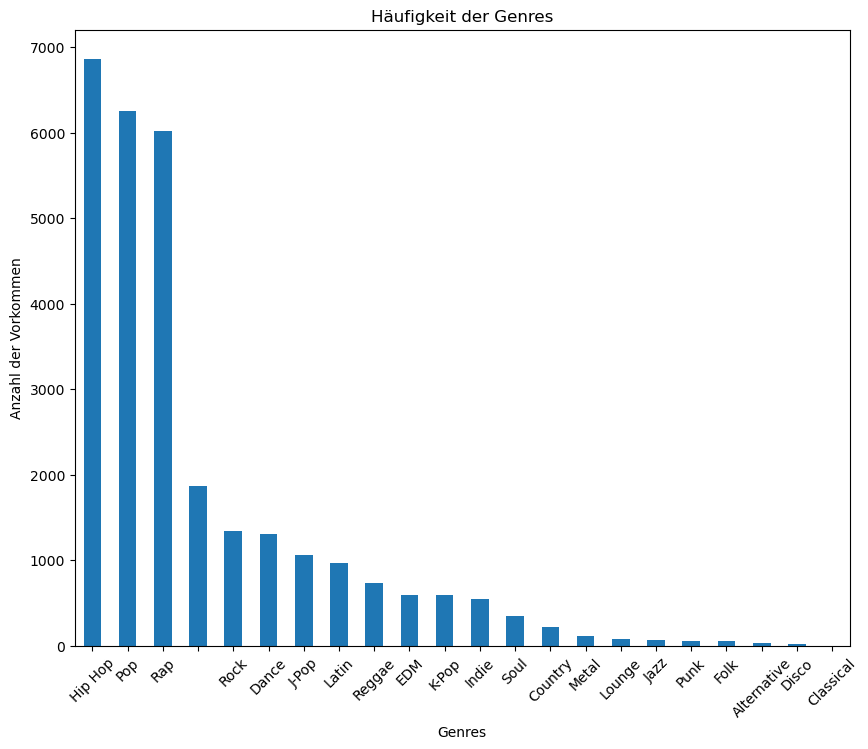

In [39]:
import matplotlib.pyplot as plt

# Berechnen der Summe jeder Genre-Spalte, um die Häufigkeit zu erhalten
genre_counts = df.iloc[:, -len(dummies.columns):].sum().sort_values(ascending=False)

# Erstellen des Plots
plt.figure(figsize=(10, 8))
genre_counts.plot(kind='bar')
plt.title('Häufigkeit der Genres')
plt.xlabel('Genres')
plt.ylabel('Anzahl der Vorkommen')
plt.xticks(rotation=45)
plt.show()


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns


# Definiere die Audio-Features und Genres, die analysiert werden sollen
audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                  'speechiness', 'acousticness', 'instrumentalness', 
                  'liveness', 'valence', 'tempo', 'duration_ms', 'popularity']
genres = ['Alternative', 'Classical', 'Country', 'Dance', 'Disco', 'EDM', 
          'Folk', 'Hip Hop', 'Indie', 'Jazz', 'K-Pop', 'Latin', 'Lounge', 
          'Metal', 'Pop', 'Punk', 'Rap', 'Reggae', 'Rock', 'Soul']

# Anzahl der Plots
num_plots = len(audio_features) * len(genres)

# Bestimme die Anzahl der Spalten und Zeilen für die Subplots
num_columns = 5
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

# Erstelle eine große Figure für alle Subplots
plt.figure(figsize=(num_columns * 5, num_rows * 4))

# Erstelle für jedes Genre-Audio-Feature-Paar einen Subplot
for i, genre in enumerate(genres):
    for j, feature in enumerate(audio_features):
        plt.subplot(num_rows, num_columns, i * len(audio_features) + j + 1)
        sns.scatterplot(data=df, x=feature, y=genre, alpha=0.5)
        plt.title(f'{genre} vs {feature}')
        plt.xlabel(feature)
        plt.ylabel('Presence')
        plt.tight_layout()

plt.show()


/var/folders/01/20c31_qj5yb17hfd63hlyfl80000gn/T/ipykernel_3828/4233114015.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/01/20c31_qj5yb17hfd63hlyfl80000gn/T/ipykernel_3828/4233114015.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/01/20c31_qj5yb17hfd63hlyfl80000gn/T/ipykernel_3828/4233114015.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/01/20c31_qj5yb17hfd63hlyfl80000gn/T/ipykernel_3828/4233114015.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/01/20c31_qj5yb17hfd63hlyfl80000gn/T/ipykernel_3828/4233114015.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/01/20c31_qj5yb17hfd63hlyfl80000gn/T/ipykernel_3828/4233114015.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/01/20c31_qj5yb17hfd63hlyfl80000gn/T/ipykernel_3828/423311

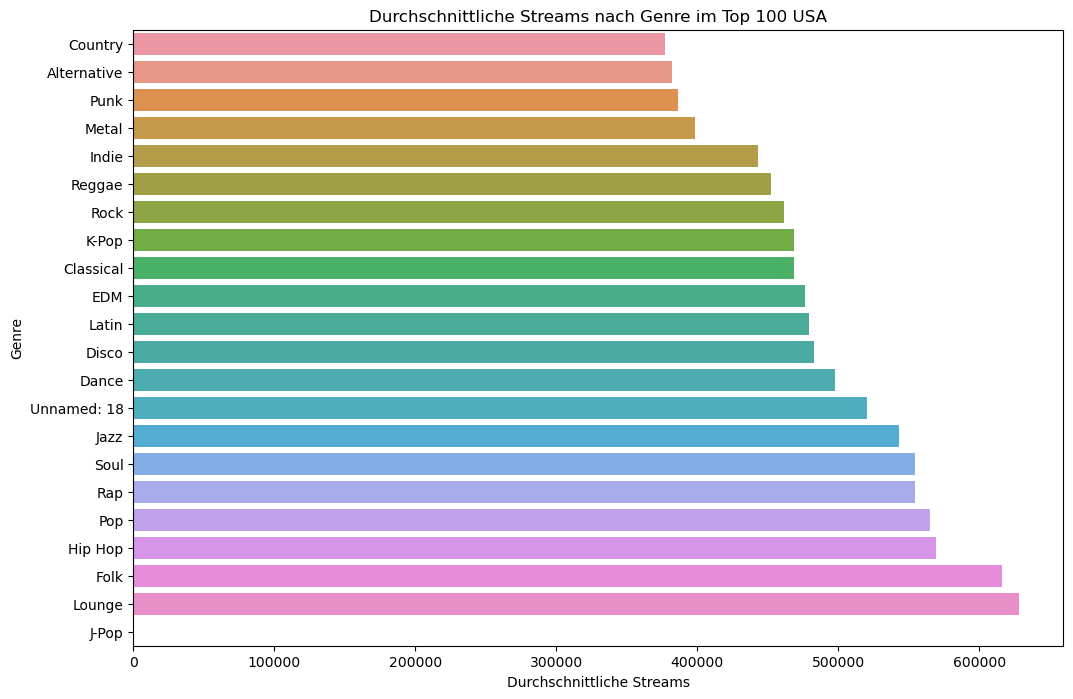

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lade den ursprünglichen Datensatz
original_data_path = '/Users/jasperkaninck/neuefische/Capstone/Notebooks/18k_clean_updated_with_dummies.csv'
original_df = pd.read_csv(original_data_path)

# Lade den Top 100 USA Datensatz
top100_usa_path = '/Users/jasperkaninck/neuefische/Capstone/Notebooks/data/Top100_UnitedStates.csv'
top100_usa_df = pd.read_csv(top100_usa_path)

# Merge der beiden Datensätze anhand der Track-ID
merged_df = pd.merge(top100_usa_df, original_df, on='track_id', how='inner')

# Genre-Spalten aus dem ursprünglichen DataFrame
genres = original_df.columns[-22:]  # Aktualisiere dies, falls die Position der Genres anders ist

# Berechnung des durchschnittlichen Rangs für jedes Genre
average_rank_by_genre = merged_df[genres].mul(merged_df['streams'], axis=0)
average_rank_by_genre = average_rank_by_genre.replace(0, np.nan)
average_rank_by_genre = average_rank_by_genre.mean().sort_values()

# Erstellung eines Plots
plt.figure(figsize=(12, 8))
sns.barplot(x=average_rank_by_genre.values, y=average_rank_by_genre.index)
plt.title('Durchschnittliche Streams nach Genre im Top 100 USA')
plt.xlabel('Durchschnittliche Streams')
plt.ylabel('Genre')
plt.show()


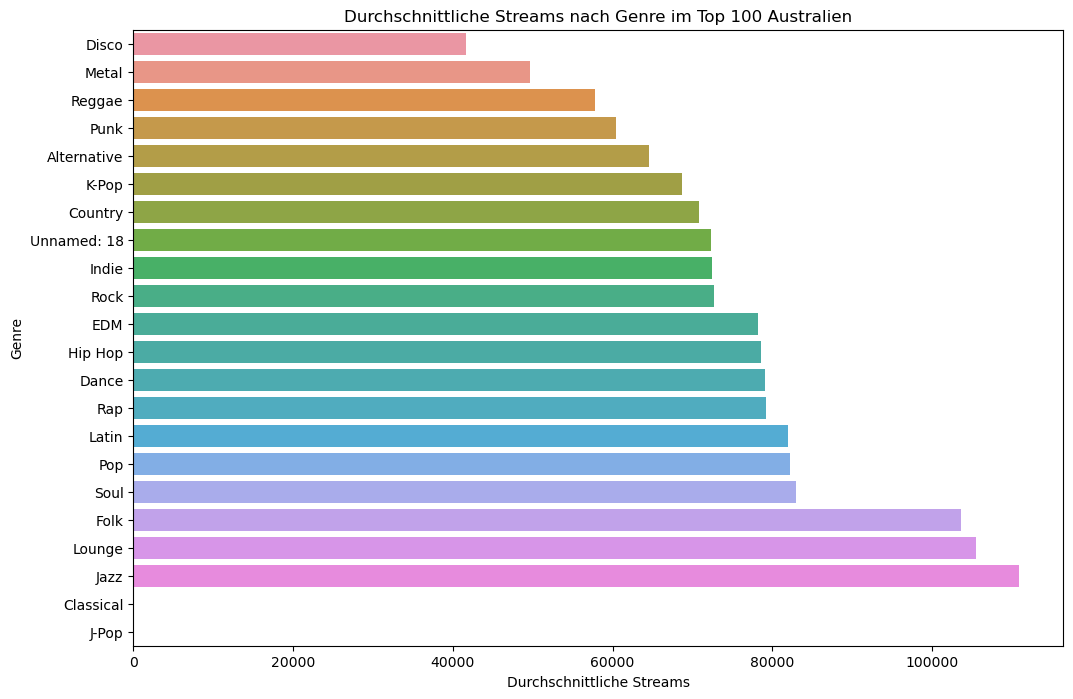

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lade den ursprünglichen Datensatz
original_data_path = '/Users/jasperkaninck/neuefische/Capstone/Notebooks/18k_clean_updated_with_dummies.csv'
original_df = pd.read_csv(original_data_path)

# Lade den Top 100 USA Datensatz
top100_aus_path = '/Users/jasperkaninck/neuefische/Capstone/Notebooks/data/Top100_Australia.csv'
top100_aus_df = pd.read_csv(top100_aus_path)

# Merge der beiden Datensätze anhand der Track-ID
merged_df = pd.merge(top100_aus_df, original_df, on='track_id', how='inner')

# Genre-Spalten aus dem ursprünglichen DataFrame
genres = original_df.columns[-22:]  # Aktualisiere dies, falls die Position der Genres anders ist

# Berechnung des durchschnittlichen Rangs für jedes Genre
average_rank_by_genre = merged_df[genres].mul(merged_df['streams'], axis=0)
average_rank_by_genre = average_rank_by_genre.replace(0, np.nan)
average_rank_by_genre = average_rank_by_genre.mean().sort_values()

# Erstellung eines Plots
plt.figure(figsize=(12, 8))
sns.barplot(x=average_rank_by_genre.values, y=average_rank_by_genre.index)
plt.title('Durchschnittliche Streams nach Genre im Top 100 Australien')
plt.xlabel('Durchschnittliche Streams')
plt.ylabel('Genre')
plt.show()
